In [ ]:
#pip install watermark
%load_ext watermark

In [ ]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
data_demo = pd.read_csv('/ml/data/weights_heights.csv')

# Реализуйте класс SGDRegressor. Спецификация:
класс наследуется от sklearn.base.BaseEstimator
конструктор принимает параметры eta – шаг градиентного спуска (по умолчанию $10^{-3}$) и n_iter – число проходов по выборке (по умолчанию 10)

также в конструкторе должны создаваться списки mse_ и weights_ для отслеживания значений среднеквадратичной ошибки и вектора весов по итерациям градиентного спуска

Класс имеет методы fit и predict

Метод fit принимает матрицу X и вектор y (объекты numpy.array), добавляет к матрице X слева столбец из единиц, инициализирует вектор весов w нулями и в цикле с числом итераций n_iter обновляет веса (см. статью), а также записывает получившиеся на данной итерации значения среднеквадратичной ошибки (именно MSE, SE слишком большими будут) и вектор весов w в предназначенные для этого списки.

В конце метод fit создает переменную w_, в которой хранится тот вектор весов, при котором ошибка минимальна

Метод fit должен возвращать текущий экземпляр класса SGDRegressor, т.е. self

Метод predict принимает матрицу X, добавляет к ней слева столбец из единиц и возвращает вектор прогнозов модели, используя созданный методом fit вектор весов w_.

In [10]:
from sklearn.metrics import mean_squared_error

class SGDRegressor(BaseEstimator):
    def __init__(self,eta=10**-3,n_iter=10,verbose=0):
        self.eta=eta
        self.n_iter=n_iter
        self.mse_=[]
        self.weights_=[]       
        self.verbose=verbose
        
    def calc_y_pred(self,x):        
        return self.weights_[0]+self.weights_[1]*x
        
    def fit(self,X,y):        
        dim=X.shape[0]
        pbar = tqdm(total=self.n_iter*dim)
        self.weights_=[.0,1.]        
        y_pred=np.zeros(dim)
        self.mse_=0
        tmse=[]
        tw=[]
        
        for n in range(self.n_iter):                        
            for i in range(dim):#прогоняем по рядам                
                nu=self.eta*(y[i]-self.weights_[0]-self.weights_[1]*X[i])                                
                self.weights_[0]+=nu
                self.weights_[1]+=nu*X[i]
                               
                y_pred=np.apply_along_axis(self.calc_y_pred, 0, X)
                tmse.append(mean_squared_error(y, y_pred))
                tw.append(self.weights_)  
                pbar.update(1)
                
        self.mse_=min(tmse)
        ind=tmse.index(self.mse_)
        self.weights_=tw[ind]
        if self.verbose>0:
            print('min mse: ',self.mse_)
            print('index: ',ind)
            print('size: ',len(tmse))
            
        pbar.close()
                   
        
                
            #if self.verbose>0:
             #   self.mse_=mean_squared_error(y, y_pred)
              #  print('N',(n+1),': mse_train=',self.mse_)
                
    def predict(self,X):
        return np.apply_along_axis(self.calc_y_pred, 0, X)

In [ ]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вес (фунты)')
plt.ylabel('Рост (дюймы)');

In [4]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

#Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([X_train.shape[0], 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([X_valid.shape[0], 1]))

In [11]:
sgd=SGDRegressor(verbose=1)
sgd.fit(X_train_scaled,y_train)

y_pred=sgd.predict(X_valid_scaled)
m1=mean_squared_error(y_valid, y_pred)
print('mse_pred= ',m1)

100%|██████████| 175000/175000 [00:35<00:00, 4934.31it/s]

min mse:  2.71513523577
index:  12626
size:  175000
mse_pred=  2.6758568913


In [13]:
from sklearn.linear_model import LinearRegression 
regr = LinearRegression().fit(X_train_scaled.reshape(-1, 1),y_train)

y_pred=regr.predict(X_valid_scaled.reshape(-1, 1))
m2=mean_squared_error(y_valid, y_pred)
print('mse_pred= ',m2)

print(m1-m2)
print('В каком знаке после разделителя отличаются MSE линейной регрессии и SGDRegressor для отложенной выборки? 3')

mse_pred=  2.67083076767
0.00502612363698
В каком знаке после разделителя отличаются MSE линейной регрессии и SGDRegressor для отложенной выборки? 3


## 1.2. Логистическая регрессия и SGD

In [ ]:
print('По какой формуле будут пересчитываться веса логистической регрессии при обучении стохастическим градиентным спуском? 4')

In [30]:
#конструктор принимает параметры eta – шаг градиентного спуска (по умолчанию $10^{-3}$), 
#n_iter – число проходов по выборке (по умолчанию 10) и C – коэффициент регуляризации
from sklearn.metrics import roc_auc_score

class SGDClassifier(BaseEstimator):
    def __init__(self,eta=10**-3,C=1,n_iter=10,verbose=0):
        self.eta=eta
        self.n_iter=n_iter
        self.verbose=verbose
        self.C=C
        #также в конструкторе должны создаваться списки loss_ и weights_ для отслеживания значений логистических потерь и 
        #вектора весов по итерациям градиентного спуска
        self.loss_=[]
        self.weights_=[]
    
    def sigma(self, z):
        lim=100
        z = z.flatten()
        z[z > lim] = lim
        z[z < -lim] = -lim
        return 1. / (1 + np.exp(-z))
    
    def calcSigmaAxis(self,X):
        return np.apply_along_axis(self.calcSigma, 1, X)
            
    def calcSigma(self,X):
        return self.sigma(np.dot(self.weights_.T,X))[0]
    
        
    
    def fit(self,X,y):
        eta=self.eta
        n_iter=self.n_iter        
        C=self.C
        y_true = list(map(lambda y: 0 if y<0 else 1 ,y))#Класс объекта
        
        
        dim=X.shape[0]        
        _X=np.insert(X,0,np.ones(dim),1)
        dim1=_X.shape[1]
        self.weights_=np.zeros(dim1)
        y_scores=np.zeros(dim)
        y_pred=np.zeros(dim)
        self.loss_=[]
        tweight=[]
    
        pbar = tqdm(total=self.n_iter*dim)
                
        for n in range(n_iter):            
            for i in range(dim):
                gradient=self.sigma(-1*np.dot(y[i]*self.weights_.T,_X[i]))[0]
                delta=[C*y[i]*xx*gradient-(0 if j==0 else 1)*ww for xx, ww,j in zip(_X[i], self.weights_,range(dim1))]
                self.weights_=np.array([ww+eta*dt for ww,dt in zip(self.weights_,delta)])
                
                #предсказание                
                y_scores=self.calcSigmaAxis(_X)                
                self.loss_.append(log_loss(y_true, y_scores))
                tweight.append(self.weights_)                
                pbar.update(1)
                
        min_loss=min(self.loss_)
        ind=self.loss_.index(min_loss)
        self.weights_=tweight[ind]
        if self.verbose>0:
            print('min_loss: ',min_loss)
            print('index: ',ind)   
                
        pbar.close()
        
    #Метод predict_proba принимает матрицу X, добавляет к ней слева столбец из единиц и 
    #возвращает матрицу прогнозов модели (такую же, какую возвращают методы predict_proba моделей sklearn), 
    #используя созданный методом fit вектор весов w_
    def predict_proba(self,X):
        dim=X.shape[0]
        _X=np.insert(X,0,np.ones(dim),1)
        y_scores=np.zeros(dim)
        
        for i in range(dim):
            y_scores[i]=self.calcSigma(X[i])
        
        return y_scores
    
    #Метод predict вызывает метод  predict_proba и возвращает вектор ответов: 
    #-1, если предсказанная вероятность класса 1 меньше 0.5 и 1 – в противном случае
    def predict(self,X):
        y_scores=self.predict_proba(X)
        y_pred=list(map(lambda y: -1 if y<0.5 else 1 ,y_scores))
        
        return y_pred
        

### Проверим SGDClassifier на данных UCI по раку молочной железы.

In [18]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
# поменяем метки в y с 0 на -1
X, y = cancer.data, [-1 if i == 0 else 1 for i in cancer.target]


#Выделим 70% под обучение, 30% – под проверку и масштабируем выборку.
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                     test_size=0.3,
                                                     random_state=17)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)








  0%|          | 0/3980 [00:00<?, ?it/s]






  0%|          | 14/3980 [00:00<00:28, 139.39it/s]






  1%|          | 31/3980 [00:00<00:27, 144.63it/s]






  1%|          | 46/3980 [00:00<00:27, 145.32it/s]






  2%|▏         | 62/3980 [00:00<00:26, 147.39it/s]






  2%|▏         | 77/3980 [00:00<00:26, 147.99it/s]






  2%|▏         | 93/3980 [00:00<00:25, 149.98it/s]






  3%|▎         | 107/3980 [00:00<00:26, 146.72it/s]






  3%|▎         | 123/3980 [00:00<00:25, 149.98it/s]






  3%|▎         | 138/3980 [00:00<00:25, 149.12it/s]






  4%|▍         | 153/3980 [00:01<00:26, 146.77it/s]






  4%|▍         | 168/3980 [00:01<00:26, 144.23it/s]






  5%|▍         | 184/3980 [00:01<00:25, 148.52it/s]






  5%|▌         | 199/3980 [00:01<00:25, 148.23it/s]






  5%|▌         | 215/3980 [00:01<00:25, 150.08it/s]






  6%|▌         | 230/3980 [00:01<00:25, 147.17it/s]






  6%|▌         | 245/3980 [00:01<00:25, 146.85it/s]






  7%|▋         | 260/398

 39%|███▉      | 1571/3980 [00:10<00:17, 138.27it/s]






 40%|███▉      | 1586/3980 [00:11<00:17, 139.46it/s]






 40%|████      | 1602/3980 [00:11<00:16, 143.41it/s]






 41%|████      | 1617/3980 [00:11<00:16, 142.52it/s]






 41%|████      | 1633/3980 [00:11<00:16, 145.81it/s]






 41%|████▏     | 1648/3980 [00:11<00:16, 145.66it/s]






 42%|████▏     | 1664/3980 [00:11<00:15, 148.36it/s]






 42%|████▏     | 1679/3980 [00:11<00:15, 146.05it/s]






 43%|████▎     | 1694/3980 [00:11<00:15, 145.56it/s]






 43%|████▎     | 1709/3980 [00:11<00:15, 145.95it/s]






 43%|████▎     | 1725/3980 [00:11<00:15, 147.37it/s]






 44%|████▎     | 1740/3980 [00:12<00:15, 143.41it/s]






 44%|████▍     | 1756/3980 [00:12<00:15, 145.16it/s]






 44%|████▍     | 1771/3980 [00:12<00:15, 145.11it/s]






 45%|████▍     | 1787/3980 [00:12<00:14, 148.28it/s]






 45%|████▌     | 1802/3980 [00:12<00:14, 148.04it/s]






 46%|████▌     | 1817/3980 [00:12<00:15, 141.94it/s]





 79%|███████▊  | 3131/3980 [00:21<00:05, 143.96it/s]






 79%|███████▉  | 3146/3980 [00:21<00:05, 145.54it/s]






 79%|███████▉  | 3162/3980 [00:21<00:05, 147.04it/s]






 80%|███████▉  | 3177/3980 [00:22<00:05, 147.63it/s]






 80%|████████  | 3193/3980 [00:22<00:05, 149.12it/s]






 81%|████████  | 3209/3980 [00:22<00:05, 149.75it/s]






 81%|████████  | 3225/3980 [00:22<00:05, 150.90it/s]






 81%|████████▏ | 3241/3980 [00:22<00:05, 146.45it/s]






 82%|████████▏ | 3256/3980 [00:22<00:04, 145.98it/s]






 82%|████████▏ | 3271/3980 [00:22<00:04, 145.47it/s]






 83%|████████▎ | 3286/3980 [00:22<00:04, 146.70it/s]






 83%|████████▎ | 3301/3980 [00:22<00:04, 145.18it/s]






 83%|████████▎ | 3316/3980 [00:23<00:04, 142.24it/s]






 84%|████████▎ | 3331/3980 [00:23<00:04, 140.58it/s]






 84%|████████▍ | 3346/3980 [00:23<00:04, 141.40it/s]






 84%|████████▍ | 3361/3980 [00:23<00:04, 139.21it/s]






 85%|████████▍ | 3376/3980 [00:23<00:04, 140.56it/s]





min mse:  0.0487860103644
index:  3946


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


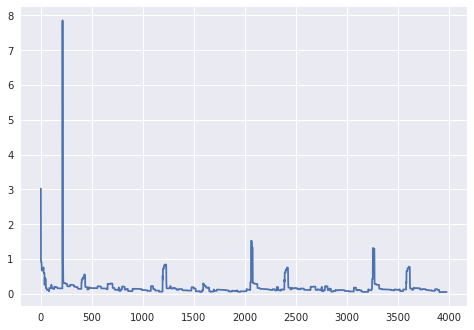

In [31]:
#cls=SGDClassifier(verbose=0, eta=10**-4,C=0.01,n_iter=25)
#cls=SGDClassifier(verbose=0, C=1)
cls=SGDClassifier(verbose=1,C=1000)
cls.fit(X_train_scaled,y_train)#,show_index=0

plt.plot(cls.loss_)

In [32]:
#получаем список показателей которые сильнее всего влияют на предсказания
ww=list(map(lambda x: abs(x),cls.weights_[1:]))
print ('3. Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели SGDClassifier?',cancer.feature_names[list(ww).index(np.max(ww))])

3. Какой признак сильнее остальных влияет на вероятность того, что опухоль доброкачественна, согласно обученной модели SGDClassifier? worst concavity


# 1.3. Логистическая регрессия и SGDClassifier в задаче классификации отзывов к фильмам

In [ ]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

In [ ]:
# поменяйте путь к файлу
reviews_train = load_files("/ml/data/imdb_reviews/aclImdb/train")
text_train, y_train = reviews_train.data, reviews_train.target


reviews_test = load_files("/ml/data/imdb_reviews/aclImdb/test")
text_test, y_test = reviews_test.data, reviews_test.target

Обучим на имеющихся данных CountVectorizer, считая биграммы, то есть перейдем к 
разреженному представлению данных, где каждому уникальному слову и паре подряд идущих слов в обучающей
выборке соответсвует признак. Всего таких признаков получается более 1.5 млн.

In [ ]:
%%time
cv = CountVectorizer(ngram_range=(1, 2))
X_train = cv.fit_transform(text_train)
X_test = cv.transform(text_test)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
clf=SGDClassifier(random_state=17)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

aUC_ROC=roc_auc_score(y_test, y_pred)
print ('AUC_ROC=' , aUC_ROC)

In [ ]:
print('Чем sklearn-реализация стохастического классификатора более продвинута, чем SGDClassifier, который мы реализовали? Отметьте все подходящие варианты.')
print('Изменяемый шаг градиентного спуска - да')
print('Реализован линейный SVM - да')
print('Реализована ранняя остановка во избежание переобучения -?')
print('Есть распараллеливание по процессорам - да')
print('Можно обучать LASSO')
print('Поддерживается онлайн-обучение деревьев решений')
print('Поддерживается mini-batch подход (обновление весов по нескольким объектом сразу, а не по одному) -да')

In [ ]:
%%time
#Проведите 100 итераций SGD-логрегрессии (опять random_state=17) 
#на той же выборке. Опять замерьте время обучения модели и обратите внимание, 
#насколько оно меньше, чем время обучения логистической регрессии.


clf=SGDClassifier(random_state=17,n_iter=100,loss='log')
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

aUC_ROC=roc_auc_score(y_test, y_pred)
print ('AUC_ROC=' , aUC_ROC)

In [ ]:
print('1.5. В каком знаке после разделителя отличаются ROC AUC на тестовой выборке логистической регрессии и SGD-классификатора Sklearn с логистической функцией потерь? - 2')